<span style="color:red">Contexto:  </span>  

En este proyecto sólo de mostrarán los métodos que conozco, estos métodos son utilizados para filtrar outliers, escalar datos, aplicar modelos de ML, etc. La idea es sólo mostrar los conocimientos y sé que algunos de estos sólo deben ser utilizados en determinadas circuntacias.
Estas circuntacias serán asumidas, pero yo sé que se deben revisar estas, por ejemplo queremos utilizar un filtrado de outliers a través de z-score, entonces debemos verificar que los datos tengan distribución. Esto se puede realizar utilizando una gráfica Q-Q, un test de hipotesis como el test de Shapiro.


Fuentes de información:  
https://www.kaggle.com/datasets/jacksondivakarr/phone-classification-dataset  
https://www.kaggle.com/code/xkshitijx/using-randomforest-naivebayes/notebook  


ML Life cycle  
https://www.youtube.com/watch?v=xhB-dmKmzRk&ab_channel=KrishNaik  
https://github.com/krishnaik06/Advanced-House-Price-Prediction-/blob/master/Exploratory%20Data%20Analysis%20Part%201.ipynb  
https://neptune.ai/blog/life-cycle-of-a-machine-learning-project  
https://www.datacamp.com/blog/machine-learning-lifecycle-explained  
https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning-lifecycle.html  

In [26]:
# Fase de análisis de los datos
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats   
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import gdown

#if False:
if True:    
    # Outlier
    from sklearn.covariance import MinCovDet
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.linear_model import HuberRegressor, Ridge
    from sklearn.preprocessing import RobustScaler
    from sklearn.ensemble import IsolationForest
    from scipy.stats.mstats import winsorize


#if False:
if True:    
    # Fase de modelamiento de datos usando algoritmos de ML
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder    

# escalamiento:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # estandarizacion normal 

# Modelos de ML
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.neighbors import NearestCentroid
import xgboost as xgb

#Medidas de modelos ML
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Estudio multivariable

In [50]:
#if True:
if False:    
    
    with open("dict_df_outlier.pickle", "rb") as archivo:
        dict_cargado = pickle.load(archivo)    

    data=dict_cargado["filtrar_outliers_trimming"]
    orden_leyenda = ['Precio muy bajo','Precio bajo','Precio medio','Precio alto']
    dict_orden={u:v for u,v in zip(list(range(0,4)),orden_leyenda)}
    data["price_range_sort"]=data["price_range"]
    data["price_range"]=data["price_range"].map(dict_orden)

    columnas_numericas=list(data.select_dtypes(exclude=["category"]).columns)
    columnas_numericas.append("price_range")

    columnas_category=data.select_dtypes(include=["category"]).columns

    sns.pairplot( data = data[list(columnas_numericas)],hue="price_range")
    plt.tight_layout()
    plt.show()

## Estudio de correlaciones entre variables:
***Ver correlaciones de las variables en escala normal***:

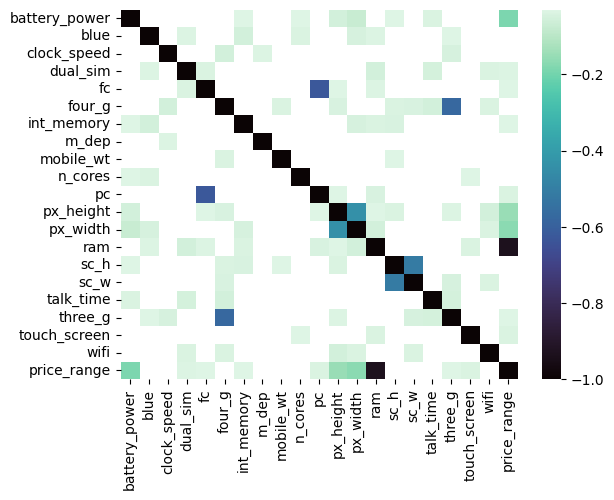

In [27]:
with open("dict_df_outlier.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo)

data=dict_cargado["filtrar_outliers_trimming"]

umbral = 0.03
corr_matrix=abs(data.corr())
boolean_matrix =np.where(corr_matrix < umbral, True, False)

fig = plt.figure()                    
sns.heatmap(-corr_matrix, cmap='mako', mask=boolean_matrix)
plt.show()

***Ver correlaciones de las variables en escala logaritmica***:

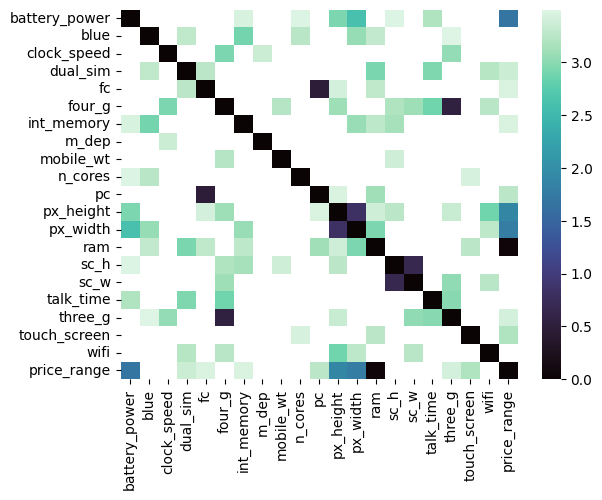

In [28]:
with open("dict_df_outlier.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo)    

data=dict_cargado["filtrar_outliers_trimming"]

umbral = 3.5
corr_matrix= -np.log(abs(data.corr()))
boolean_matrix = np.where(corr_matrix < umbral, False,True)

fig = plt.figure()
sns.heatmap(corr_matrix, cmap='mako', mask=boolean_matrix)
plt.show()

***Ejemplo de eliminación de variables no correlacionadas con la variable dependiente***: 

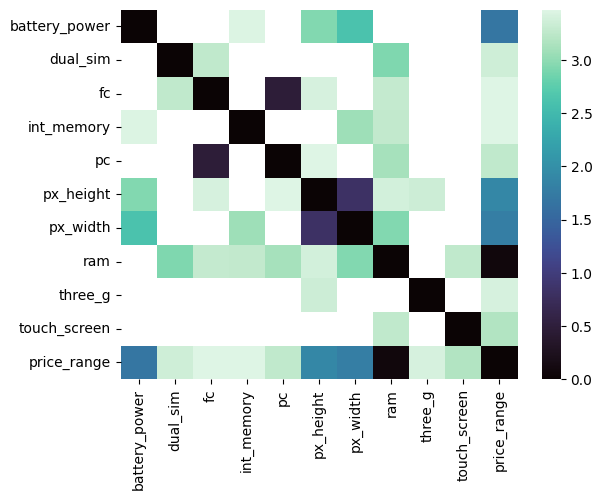

In [29]:
with open("dict_df_outlier.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo)    

data=dict_cargado["filtrar_outliers_trimming"]


data_correl=data
umbral = 3.5
corr_matrix= -np.log(abs(data_correl.corr()))
boolean_matrix = np.where(corr_matrix < umbral, False,True)

for col,aff in zip(list(data_correl.columns),list(boolean_matrix[-1,:])):   # list(boolean_matrix[-1,:]) fila correspondiente a la var dep
    if aff==True:
        data_correl = data_correl.drop(col, axis = 1)

corr_matrix= -np.log(abs(data_correl.corr()))
boolean_matrix = np.where(corr_matrix < umbral, False,True)

fig = plt.figure()
sns.heatmap(corr_matrix, cmap='mako', mask=boolean_matrix)
plt.show()

In [30]:
umbral = 3.5

with open("dict_df_outlier.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo)    

for outlier_method in list(dict_cargado.keys()):
    #outlier_method="filtrar_outliers_trimming"
    data_correl=dict_cargado[outlier_method]  # bs_data: data paso anterior del método que tiene el nombre==keys
    method_dict={}
    # Caso: quitamos var indep poco correlacionadas con var dep
    corr_matrix= -np.log(abs(data_correl.corr()))
    boolean_matrix = np.where(corr_matrix < umbral, False,True)

    for col,aff in zip(list(data_correl.columns),list(boolean_matrix[-1,:])):   # list(boolean_matrix[-1,:]) fila correspondiente a la var dep    
        if aff==True:
            data_correl = data_correl.drop(col, axis = 1)

    method_dict["filtrado_correlacion"]=data_correl

# Caso: No quitamos var indep poco correlacionadas con var dep
    method_dict["no_filtrado_correlacion"]=dict_cargado[outlier_method]

    # agregamos un dict al dict del nivel anterior
    dict_cargado[outlier_method]=method_dict

with open("dict_df_correl.pickle", "wb") as archivo:
    pickle.dump(dict_cargado, archivo)    



# Algoritmos ML  
***División del conjunto de datos***

Forma de escalar datos:
- Escalamiento de datos vía normalización
- Escalamiento de datos vía rango [a, b]
- Escalamiento de datos vía estandarización
- Escalamiento de datos vía estandarización robusta
- Escalamiento de datos diferenciada

In [31]:
def escaled_min_max(data,columna):
    XX = data.drop([columna], axis = 1)
    y = data[columna]

    dato_dummies=pd.get_dummies(XX)    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(dato_dummies)

    X = pd.DataFrame(scaler, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test

def escaled_Standardization(data,columna):
    XX = data.drop([columna], axis = 1)
    y = data[columna]

    dato_dummies=pd.get_dummies(XX)    
    scaler = StandardScaler().fit_transform(dato_dummies)

    X = pd.DataFrame(scaler, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test


def robust_escaled_Standardization(data,columna):
    XX = data.drop([columna], axis = 1)
    y = data[columna]

    dato_dummies=pd.get_dummies(XX)    
    scaler = RobustScaler().fit_transform(dato_dummies)

    X = pd.DataFrame(scaler, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test


def without_escaled(data,columna):
    XX = data.drop([columna], axis = 1)
    y = data[columna]

    dato_dummies=pd.get_dummies(XX).astype(float)
    
    X_train , X_test , Y_train , Y_test = train_test_split(dato_dummies,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test

def diferenciado_escaled_min_max(data,columna):
    target_values = data[columna].unique()
    XX = data.drop([columna], axis = 1)
    y = data[columna]


    dato_dummies=pd.get_dummies(XX)      # data a filtrar
    var_indep=list(set(list(dato_dummies.columns))-set(columna))

    dato_dummies["price_range"]=y   

    for target_value in target_values:
        mask1=dato_dummies[columna] == target_value
        subset_df = dato_dummies[mask1]

        # Aplicar el escalado Min-Max a las columnas numéricas del subconjunto
        scaler = MinMaxScaler()
        subset_df[var_indep] = scaler.fit_transform(subset_df[var_indep])
        dato_dummies[mask1] = subset_df
    
    
    y = dato_dummies[columna]
    dato_dummies = dato_dummies.drop([columna], axis = 1).astype(float)

    X = pd.DataFrame(dato_dummies, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test


def diferenciado_escaled_Standardization(data,columna):
    target_values = data[columna].unique()
    XX = data.drop([columna], axis = 1)
    y = data[columna]


    dato_dummies=pd.get_dummies(XX)      # data a filtrar
    var_indep=list(set(list(dato_dummies.columns))-set(columna))

    dato_dummies["price_range"]=y   

    for target_value in target_values:
        mask1=dato_dummies[columna] == target_value
        subset_df = dato_dummies[mask1]

        # Aplicar el escalado Min-Max a las columnas numéricas del subconjunto
        scaler = StandardScaler()
        subset_df[var_indep] = scaler.fit_transform(subset_df[var_indep])
        dato_dummies[mask1] = subset_df

    y = dato_dummies[columna]
    dato_dummies = dato_dummies.drop([columna], axis = 1).astype(float)

    X = pd.DataFrame(dato_dummies, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test


def diferenciado_robust_escaled_Standardization(data,columna):
    target_values = data[columna].unique()
    XX = data.drop([columna], axis = 1)
    y = data[columna]


    dato_dummies=pd.get_dummies(XX)      # data a filtrar
    var_indep=list(set(list(dato_dummies.columns))-set(columna))

    dato_dummies["price_range"]=y   

    for target_value in target_values:
        mask1=dato_dummies[columna] == target_value
        subset_df = dato_dummies[mask1]

        # Aplicar el escalado Min-Max a las columnas numéricas del subconjunto
        scaler = RobustScaler()
        subset_df[var_indep] = scaler.fit_transform(subset_df[var_indep])
        dato_dummies[mask1] = subset_df

    y = dato_dummies[columna]
    dato_dummies = dato_dummies.drop([columna], axis = 1).astype(float)
    X = pd.DataFrame(dato_dummies, columns=dato_dummies.columns)
    X_train , X_test , Y_train , Y_test = train_test_split(X,y,test_size= 0.2 ,shuffle=True , random_state=1)

    y_one_hot_train = pd.get_dummies(Y_train).astype(int)
    y_one_hot_test = pd.get_dummies(Y_test).astype(int)

    return X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test



In [32]:
with open("dict_df_correl.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo)  

columna="price_range"
# outlier-> correlacion -> escalamiento


for outlier_method in list(dict_cargado.keys()):
    for name_correl_dict in dict_cargado[outlier_method].keys():
        
        data=dict_cargado[outlier_method][name_correl_dict]

        escalamiento_dict={}
        
        # escalamiento 1
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=escaled_min_max(data,columna)
        escalamiento_dict["escaled_min_max"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]

        # escalamiento 2
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=escaled_Standardization(data,columna)
        escalamiento_dict["escaled_Standardization"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]

        # escalamiento 3
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=robust_escaled_Standardization(data,columna)
        escalamiento_dict["robust_escaled_Standardization"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]

        # escalamiento 4
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=diferenciado_escaled_min_max(data,columna)
        escalamiento_dict["diferenciado_escaled_min_max"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]

        # escalamiento 5
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=diferenciado_escaled_Standardization(data,columna)
        escalamiento_dict["diferenciado_escaled_Standardization"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]
        
        # escalamiento 6
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=diferenciado_robust_escaled_Standardization(data,columna)
        escalamiento_dict["diferenciado_robust_escaled_Standardization"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]
        
        # escalamiento 7
        X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=without_escaled(data,columna)
        escalamiento_dict["without_escaled"]=[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]
        
        # fin escalamiento 
        dict_cargado[outlier_method][name_correl_dict]=escalamiento_dict


with open("dict_df_scaled.pickle", "wb") as archivo:
    pickle.dump(dict_cargado, archivo)

# Ejecutar los modelos de ml para todas las datas

***Definir grid de parametros para cada algoritmo de ML***

In [33]:
dict_parameter={}
#  Random Forest
parameters = {
    'n_estimators' : [50, 150, 500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2'],
    'n_jobs':[-1]
}
dict_parameter["Ramdon Forest"]=(RandomForestClassifier(random_state=20),parameters)

#  MultinomialNB
parameters = {
    'alpha' : [1e-0,1e-1,1e-2,1e-3,1e-4],
    'fit_prior' : [True,False]
}
dict_parameter["MultinomialNB"]=(MultinomialNB(),parameters)

# MLPClassifier
model=MLPClassifier()
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "solver":["lbfgs","sgd","adam"],
    "learning_rate":["constant","invscaling","adaptive"]
}
dict_parameter["MLPClassifier"]=(model,parameters)

# LinearSVC
model=LinearSVC()
parameters = {
    "penalty":["l1","l2"],
    "loss":["hinge","squared_hinge"],
    "C":[1e2,1e1,1e-1,1e-2],
    "max_iter":[1000],
    "intercept_scaling":[False, True],
    "multi_class":["ovr","crammer_singer"]
}
dict_parameter["LinearSVC"]=(model,parameters)

# svm.NuSVC
model=svm.NuSVC(gamma="auto")
parameters = {
    "kernel":["linear","poly","rbf","sigmoid"],
    "degree":[1,3,5,7]
}
dict_parameter["svm.NuSVC"]=(model,parameters)

# NearestCentroid
model=NearestCentroid()
parameters = { }
dict_parameter["NearestCentroid"]=(model,parameters)

# xgb.XGBClassifier
model=xgb.XGBClassifier(
    objective='binary:logistic',  # 'multi:softmax' para clasificación multiclase
    eval_metric='logloss',         # Métrica de evaluación
    use_label_encoder=False        # Desactivar la codificación automática de etiquetas
    )
parameters = {
    "kernel":["linear","poly","rbf","sigmoid"],
    "degree":[1,2,3,4,5,6,7]
}
dict_parameter["xgb.XGBClassifier"]=(model,parameters)

dict_parameter.keys()    

dict_keys(['Ramdon Forest', 'MultinomialNB', 'MLPClassifier', 'LinearSVC', 'svm.NuSVC', 'NearestCentroid', 'xgb.XGBClassifier'])

In [34]:
def grid_para_model_ml(model_name,Model,fold_cv,parameters,X_train,Y_train,X_test,Y_test,y_one_hot_train,y_one_hot_test):
    
    models_one_hot = ["MultinomialNB", "LinearSVC", "svm.NuSVC", "NearestCentroid"]

    if model_name not in models_one_hot:
        model_grid = GridSearchCV(estimator=Model, cv=fold_cv, param_grid=parameters).fit(X_train , y_one_hot_train)
        best_model=model_grid.best_estimator_
        
        print("\n" ,"Modelo:",model_name )
        y_pred_train=best_model.predict(X_train)
        eva_train=precision_score(y_one_hot_train, y_pred_train, average='micro')
        print("Presición modelo (Train):",eva_train)
        
        y_pred_test=best_model.predict(X_test)
        eva_test=precision_score(y_one_hot_test, y_pred_test, average='micro')
        print("Presición modelo (Test):",eva_test)

        accuracy = accuracy_score(y_one_hot_test, y_pred_test)
        precision = precision_score(y_one_hot_test, y_pred_test, average='macro')
        recall = recall_score(y_one_hot_test, y_pred_test, average='macro')
        f1 = f1_score(y_one_hot_test, y_pred_test, average='macro')

    else:
        model_grid = GridSearchCV(estimator=Model, cv=fold_cv, param_grid=parameters).fit(X_train , Y_train)
        best_model=model_grid.best_estimator_
        
        print("\n" ,"Modelo:",model_name )
        y_pred_train=best_model.predict(X_train)
        eva_train=precision_score(Y_train, y_pred_train, average='micro')
        print("Presición modelo (Train):",eva_train)
        
        y_pred_test=best_model.predict(X_test)
        eva_test=precision_score(Y_test, y_pred_test, average='micro')
        print("Presición modelo (Test):",eva_test)

        accuracy = accuracy_score(Y_test, y_pred_test)
        precision = precision_score(Y_test, y_pred_test, average='macro')
        recall = recall_score(Y_test, y_pred_test, average='macro')
        f1 = f1_score(Y_test, y_pred_test, average='macro')        

    return best_model,eva_train,eva_test,accuracy,precision,recall,f1


In [35]:
def medidas_models(outlier_method,dict_cargado,fold_cv,dict_parameter):
    # PArt 1: Sirve para cargar checkpoint del progeso del código.
    ruta_archivo = 'progreso.pickle'
    if os.path.exists(ruta_archivo):
        with open(ruta_archivo, "rb") as archivo:
            dict_progreso = pickle.load(archivo)    

            if outlier_method in set(dict_progreso.keys()):
                num_progreso=dict_progreso[outlier_method]
            else:
                num_progreso=-1
    else:
        dict_progreso={}
        num_progreso=-1

    count=0
    for name_correl_dict in dict_cargado[outlier_method].keys():
        for dict_scaled_name in dict_cargado[outlier_method][name_correl_dict].keys():
            if num_progreso >= count:
                count+=1
                continue
                
            if dict_scaled_name=="without_escaled":
                continue

            X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]  # datas escaladas
            dict_eva_model={}
            with open("archivo.txt", "w") as archivo:
                archivo.write(str(count)+", "+outlier_method+", "+dict_scaled_name+", "+name_correl_dict)

            for model_name in list(dict_parameter.keys()):
                    print("dict_scaled_name",dict_scaled_name,"model_name",model_name)
                    (model,parameters)=dict_parameter[model_name]
                    if model_name=="MultinomialNB":
                        if dict_scaled_name in {"escaled_Standardization","robust_escaled_Standardization","diferenciado_escaled_Standardization","diferenciado_robust_escaled_Standardization","diferenciado_escaled_min_max"}:
                            continue
                        
                    best_model,eva_train,eva_test,accuracy,precision,recall,f1=grid_para_model_ml(model_name,model,fold_cv,parameters,X_train,Y_train,X_test,Y_test,y_one_hot_train,y_one_hot_test)
                    dict_eva_model[model_name]={"best_model":best_model,"eva_train":eva_train,"eva_test":eva_test,"accuracy":accuracy,"precision":precision,"recall":recall,"f1":f1}
                    
            with open("./modelos/"+outlier_method+name_correl_dict+dict_scaled_name+".pickle", "wb") as archivo:
                pickle.dump(dict_eva_model, archivo) 
            
            
            dict_progreso[outlier_method]=count  # marcar iteracion que esta lista
            count+=1                             # establecer siguiente iteracion a realizar
            with open("progreso.pickle", "wb") as archivo: # progreso
                pickle.dump(dict_progreso, archivo)                 
                        
            dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]={"Datos":[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]}
            dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]["Dict Modelos"]=dict_eva_model
            

    with open(outlier_method+"dict_df_modelos.pickle", "wb") as archivo:
        pickle.dump(dict_cargado, archivo) 



### Entrenamiento de cada modelo para cada data

In [36]:
if False:
#if True:    
    with open("dict_df_scaled.pickle", "rb") as archivo:
        dict_cargado = pickle.load(archivo)  

    fold_cv=5

    for outlier_method in list(dict_cargado.keys()):
        medidas_models(outlier_method,dict_cargado,fold_cv,dict_parameter)

In [37]:
def juntar_medidas_models(dict_cargado):
    
    for outlier_method in dict_cargado.keys():
        for name_correl_dict in dict_cargado[outlier_method].keys():
            for dict_scaled_name in dict_cargado[outlier_method][name_correl_dict].keys():
                
                if dict_scaled_name=="without_escaled":
                    continue
                X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]  # datas escaladas

                with open("./modelos/"+outlier_method+name_correl_dict+dict_scaled_name+".pickle", "rb") as archivo:
                    dict_eva_model = pickle.load(archivo)             
                
                dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]={"Datos":[X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test]}
                dict_cargado[outlier_method][name_correl_dict][dict_scaled_name]["Dict Modelos"]=dict_eva_model
                print(outlier_method,name_correl_dict,dict_scaled_name)

    with open("./Resultados/dict_df_modelos_all.pickle", "wb") as archivo:
        pickle.dump(dict_cargado, archivo) 

In [38]:
with open("./Resultados/dict_df_scaled.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo) 
juntar_medidas_models(dict_cargado)

cuartiles filtrado_correlacion escaled_min_max
cuartiles filtrado_correlacion escaled_Standardization
cuartiles filtrado_correlacion robust_escaled_Standardization
cuartiles filtrado_correlacion diferenciado_escaled_min_max
cuartiles filtrado_correlacion diferenciado_escaled_Standardization
cuartiles filtrado_correlacion diferenciado_robust_escaled_Standardization
cuartiles no_filtrado_correlacion escaled_min_max
cuartiles no_filtrado_correlacion escaled_Standardization
cuartiles no_filtrado_correlacion robust_escaled_Standardization
cuartiles no_filtrado_correlacion diferenciado_escaled_min_max
cuartiles no_filtrado_correlacion diferenciado_escaled_Standardization
cuartiles no_filtrado_correlacion diferenciado_robust_escaled_Standardization
filtrar_outliers_zscore_dataframe filtrado_correlacion escaled_min_max
filtrar_outliers_zscore_dataframe filtrado_correlacion escaled_Standardization
filtrar_outliers_zscore_dataframe filtrado_correlacion robust_escaled_Standardization
filtrar_outl

***Ejemplo: modelo NearestCentroid usando datos filtrados usando correlación,escala mín y max, y sus outliers filtrador por cuartiles***

In [39]:
with open("./Resultados/dict_df_modelos_all.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo) 
dict_cargado["cuartiles"]["filtrado_correlacion"]["escaled_min_max"]['Dict Modelos']["NearestCentroid"]

{'best_model': NearestCentroid(),
 'eva_train': 0.67578125,
 'eva_test': 0.6223958333333334,
 'accuracy': 0.6223958333333334,
 'precision': 0.6449419787749214,
 'recall': 0.6161437520654941,
 'f1': 0.6252904546494864}

# Resultados
### Generar dataframe que resume los resultados de los modelos de ML

In [40]:
with open("./Resultados/dict_df_modelos_all.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo) 

pre_method_outlier=["cuartiles","z_score","trimming"]
mapeo_outlier={u:v for u,v in  zip(list(dict_cargado.keys()),pre_method_outlier)}

pre_method_correl=[1,0]
mapeo_correl={u:v for u,v in zip(list(dict_cargado["filtrar_outliers_trimming"].keys()),pre_method_correl)}

column_names = ['method_outlier', 'correl', 'method_scaled', 'Model_ML',"eva_train", 'eva_test',"accuracy","precision","recall","f1"]

# Crear un DataFrame vacío con las columnas especificadas
df = pd.DataFrame(columns=column_names)

for method_outlier in dict_cargado.keys():

    for method_correl in dict_cargado[method_outlier].keys():
        for method_scaled in dict_cargado[method_outlier][method_correl].keys():    
            if method_scaled=="without_escaled":
                continue
            print(method_outlier,method_correl,method_scaled)
            for model_ml in dict_cargado[method_outlier][method_correl][method_scaled]['Dict Modelos'].keys():
            
                nueva_fila=[]
                nueva_fila.append(mapeo_outlier[method_outlier])
                nueva_fila.append(mapeo_correl[method_correl])
                nueva_fila.append(method_scaled)
                nueva_fila.append(model_ml)
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["eva_train"])
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["eva_test"])
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["accuracy"])
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["precision"])
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["recall"])
                nueva_fila.append(dict_cargado[method_outlier][method_correl][method_scaled]["Dict Modelos"][model_ml]["f1"])
                
                df.loc[len(df)] = nueva_fila
        
with open("./Resultados/df_modelos_resumen.pickle", "wb") as archivo:
    pickle.dump(df, archivo)  

cuartiles filtrado_correlacion escaled_min_max
cuartiles filtrado_correlacion escaled_Standardization
cuartiles filtrado_correlacion robust_escaled_Standardization
cuartiles filtrado_correlacion diferenciado_escaled_min_max
cuartiles filtrado_correlacion diferenciado_escaled_Standardization
cuartiles filtrado_correlacion diferenciado_robust_escaled_Standardization
cuartiles no_filtrado_correlacion escaled_min_max
cuartiles no_filtrado_correlacion escaled_Standardization
cuartiles no_filtrado_correlacion robust_escaled_Standardization
cuartiles no_filtrado_correlacion diferenciado_escaled_min_max
cuartiles no_filtrado_correlacion diferenciado_escaled_Standardization
cuartiles no_filtrado_correlacion diferenciado_robust_escaled_Standardization
filtrar_outliers_zscore_dataframe filtrado_correlacion escaled_min_max
filtrar_outliers_zscore_dataframe filtrado_correlacion escaled_Standardization
filtrar_outliers_zscore_dataframe filtrado_correlacion robust_escaled_Standardization
filtrar_outl

*Mostrar mini resumen*

In [41]:
with open("./Resultados/df_modelos_resumen.pickle", "rb") as archivo:
    df_modelos_resumen = pickle.load(archivo) 
df_modelos_resumen.head(3)

,method_outlier,correl,method_scaled,Model_ML,eva_train,eva_test,accuracy,precision,recall,f1
0,cuartiles,1,escaled_min_max,Ramdon Forest,1.000000,0.935103,0.825521,0.930821,0.822308,0.872143
1,cuartiles,1,escaled_min_max,MultinomialNB,0.626302,0.585938,0.585938,0.615059,0.581192,0.592418
2,cuartiles,1,escaled_min_max,MLPClassifier,1.000000,0.953728,0.947917,0.953296,0.964511,0.958466


In [42]:
# Mostrar los mejores modelos de ML
df_modelos_resumen.sort_values(by='f1', ascending=False).head(20)

,method_outlier,correl,method_scaled,Model_ML,eva_train,eva_test,accuracy,precision,recall,f1
99,z_score,1,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
210,trimming,0,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
62,cuartiles,0,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
173,trimming,1,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
178,trimming,1,diferenciado_escaled_Standardization,xgb.XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
67,cuartiles,0,diferenciado_escaled_Standardization,xgb.XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
141,z_score,0,diferenciado_escaled_Standardization,xgb.XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
30,cuartiles,1,diferenciado_escaled_Standardization,xgb.XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
136,z_score,0,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25,cuartiles,1,diferenciado_escaled_Standardization,Ramdon Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
# Guardar en un dataframe los mejores modelos de ML
df_best_modelos=df_modelos_resumen.sort_values(by='f1', ascending=False).head(15).reset_index(drop=True)
df_best_modelos.head(2)

,method_outlier,correl,method_scaled,Model_ML,eva_train,eva_test,accuracy,precision,recall,f1
0,z_score,1,diferenciado_escaled_Standardization,Ramdon Forest,1.0,1.0,1.0,1.0,1.0,1.0
1,trimming,0,diferenciado_escaled_Standardization,Ramdon Forest,1.0,1.0,1.0,1.0,1.0,1.0


***Obtener los datos y modelos de los mejores modelos y guardarlos en un diccionario***

In [44]:
with open("./Resultados/dict_df_modelos_all.pickle", "rb") as archivo:
    dict_cargado = pickle.load(archivo) 

pre_method_outlier=["cuartiles","z_score","trimming"]
mapeo_outlier={u:v for u,v in  zip(list(dict_cargado.keys()),pre_method_outlier)}
mapeo_outlier = {v: k for k, v in mapeo_outlier.items()}

pre_method_correl=[1,0]
mapeo_correl={u:v for u,v in zip(list(dict_cargado["filtrar_outliers_trimming"].keys()),pre_method_correl)}
mapeo_correl = {v: k for k, v in mapeo_correl.items()}

dict_modelos={}

for i in range(len(df_best_modelos)):

    method_outlier=df_best_modelos.iloc[i,:]["method_outlier"]
    correl=df_best_modelos.iloc[i,:]["correl"]
    method_scaled=df_best_modelos.iloc[i,:]["method_scaled"]
    mapeo_outlier[method_outlier],mapeo_correl[correl],method_scaled
    modelo=df_best_modelos.iloc[i,:]["Model_ML"]

    datos=dict_cargado[mapeo_outlier[method_outlier]][mapeo_correl[correl]][method_scaled]['Datos']
    config_model=dict_cargado[mapeo_outlier[method_outlier]][mapeo_correl[correl]][method_scaled]['Dict Modelos'][modelo]['best_model']
    
    dict_modelos[i]=[datos,config_model] 

In [45]:
# Mostrar ejemplo:
i=1
dict_modelos[i]=[datos,config_model] # diccionario que contiene los datos transformador y el modelo de ML entrenado 
df_best_modelos.head(2)   # Dataframe que contiene el rendimiento y transformación de los modelos de ML

,method_outlier,correl,method_scaled,Model_ML,eva_train,eva_test,accuracy,precision,recall,f1
0,z_score,1,diferenciado_escaled_Standardization,Ramdon Forest,1.0,1.0,1.0,1.0,1.0,1.0
1,trimming,0,diferenciado_escaled_Standardization,Ramdon Forest,1.0,1.0,1.0,1.0,1.0,1.0


### Mostrar medidas de rendimiento de los mejores modelos de ML

Modelo: Ramdon Forest
method_outlier                                 z_score
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 0, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


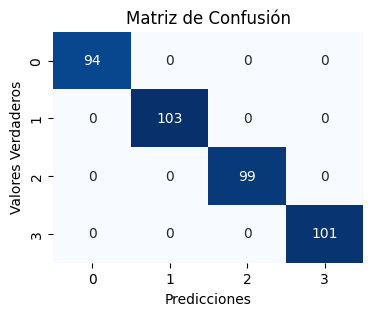

Modelo: Ramdon Forest
method_outlier                                trimming
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 1, dtype: object
precision: 0.9713541666666666
Recall: 0.9713541666666666
F1-score: 0.9711502665471755
Accuracy: 0.9713541666666666


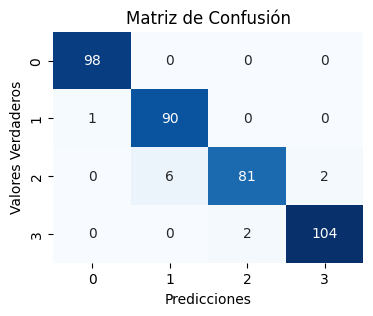

Modelo: Ramdon Forest
method_outlier                               cuartiles
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 2, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


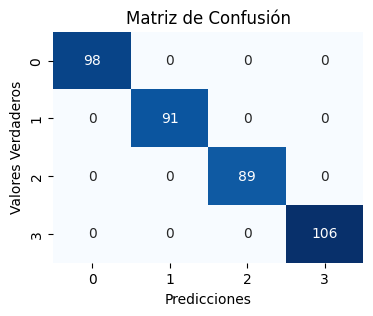

Modelo: Ramdon Forest
method_outlier                                trimming
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 3, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


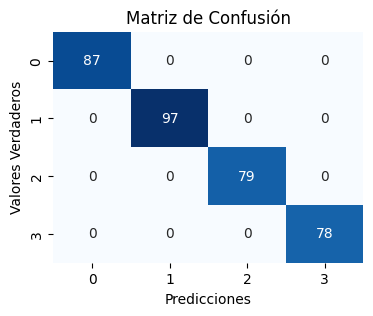

Modelo: xgb.XGBClassifier
method_outlier                                trimming
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 4, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


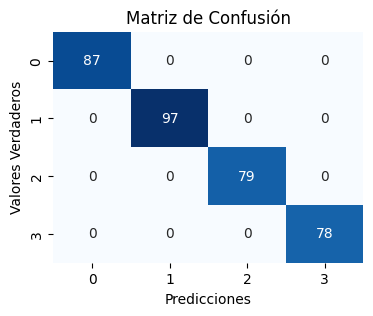

Modelo: xgb.XGBClassifier
method_outlier                               cuartiles
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 5, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


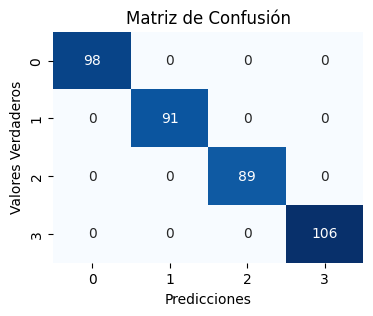

Modelo: xgb.XGBClassifier
method_outlier                                 z_score
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 6, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


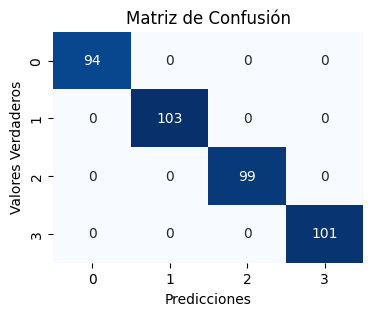

Modelo: xgb.XGBClassifier
method_outlier                               cuartiles
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 7, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


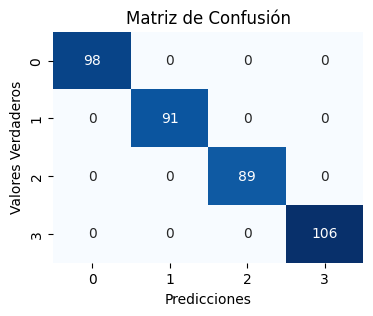

Modelo: Ramdon Forest
method_outlier                                 z_score
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 8, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


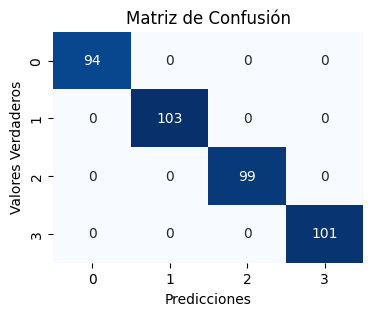

Modelo: Ramdon Forest
method_outlier                               cuartiles
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                                 Ramdon Forest
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 9, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


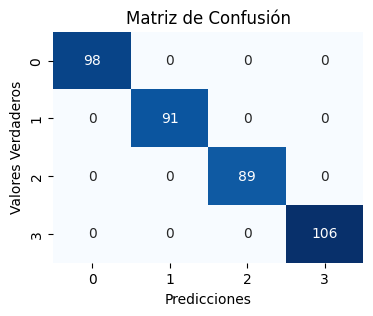

Modelo: xgb.XGBClassifier
method_outlier                                trimming
correl                                               0
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 10, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


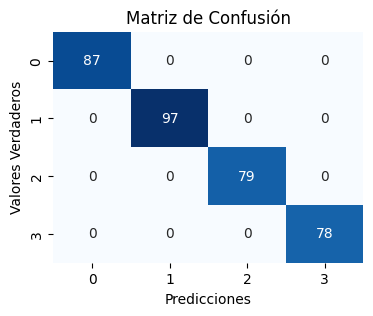

Modelo: xgb.XGBClassifier
method_outlier                                 z_score
correl                                               1
method_scaled     diferenciado_escaled_Standardization
Model_ML                             xgb.XGBClassifier
eva_train                                          1.0
eva_test                                           1.0
accuracy                                           1.0
precision                                          1.0
recall                                             1.0
f1                                                 1.0
Name: 11, dtype: object
precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


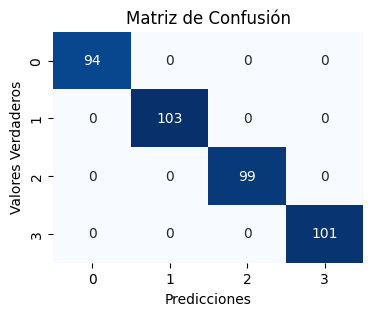

Modelo: LinearSVC
method_outlier                   trimming
correl                                  0
method_scaled     escaled_Standardization
Model_ML                        LinearSVC
eva_train                        0.992647
eva_test                         0.982405
accuracy                         0.982405
precision                        0.982166
recall                           0.980891
f1                               0.981462
Name: 12, dtype: object
precision: 0.9824046920821115
Recall: 0.9824046920821115
F1-score: 0.9823584459110223
Accuracy: 0.9824046920821115


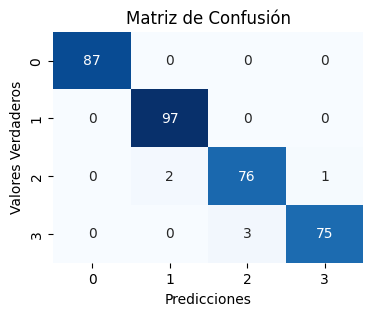

Modelo: LinearSVC
method_outlier                          trimming
correl                                         0
method_scaled     robust_escaled_Standardization
Model_ML                               LinearSVC
eva_train                               0.988235
eva_test                                0.979472
accuracy                                0.979472
precision                               0.979116
recall                                  0.977686
f1                                      0.978273
Name: 13, dtype: object
precision: 0.9794721407624634
Recall: 0.9794721407624634
F1-score: 0.9794228652563222
Accuracy: 0.9794721407624634


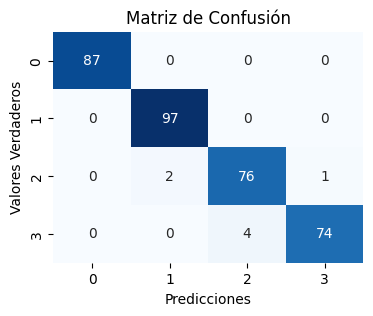

Modelo: LinearSVC
method_outlier                  cuartiles
correl                                  1
method_scaled     escaled_Standardization
Model_ML                        LinearSVC
eva_train                        0.980469
eva_test                         0.971354
accuracy                         0.971354
precision                        0.971109
recall                           0.970064
f1                               0.970121
Name: 14, dtype: object
precision: 0.9713541666666666
Recall: 0.9713541666666666
F1-score: 0.9711502665471755
Accuracy: 0.9713541666666666


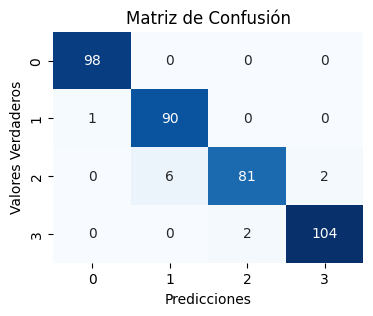

In [46]:
dic_var_dep={u:v for u,v in zip([(0,0,0,1),(0,1,0,0),(0,0,1,0),(1,0,0,0)],[0,1,2,3])}

l_accuracy_score,l_precision_score,l_recall_score,l_f1_score=[],[],[],[]

for i in list(dict_modelos.keys()):
    model_name=df_best_modelos.iloc[i,:]["Model_ML"]
    datos,model=dict_modelos[i]
    X_train , X_test , Y_train , Y_test, y_one_hot_train, y_one_hot_test=datos
    Y_test = list(Y_test)  # Y_test data series

    y_pred_test = model.predict(X_test)
    print("Modelo:", model_name)
    print(df_best_modelos.iloc[i,:])    
    if len(y_pred_test.shape)==2:
        y_pred_test_adj=[]
        for ii in range(len(list(y_pred_test))):
            if tuple(y_pred_test[ii,:])==(0, 1, 0, 1):
                print(y_pred_test[ii,:],ii)
            y_pred_test_adj.append(dic_var_dep[tuple(y_pred_test[ii,:])])
        y_pred_test=y_pred_test_adj

    
    matriz_confusion = confusion_matrix(Y_test, y_pred_test)
    precision = precision_score(Y_test, y_pred_test, average='micro')
    l_precision_score.append(precision)
    print("precision:", precision)

    recall = recall_score(Y_test, y_pred_test, average='weighted')  # También puedes cambiar 'weighted' a 'micro', 'macro', etc.
    print("Recall:", recall)
    l_recall_score.append(recall)

    # F1-score
    f1 = f1_score(Y_test, y_pred_test, average='weighted')  # También puedes cambiar 'weighted' a 'micro', 'macro', etc.
    print("F1-score:", f1)
    l_f1_score.append(f1)

    # Accuracy
    accuracy = accuracy_score(Y_test, y_pred_test)
    print("Accuracy:", accuracy)
    l_accuracy_score.append(accuracy)

    # Crear un mapa de calor con seaborn
    plt.figure(figsize=(4, 3))
    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores Verdaderos")
    plt.show()            
    

### Hacer mapa de calor de las medidas de rendiemiento asociadas a los modelos de ML

<Axes: ylabel='Model_ML'>

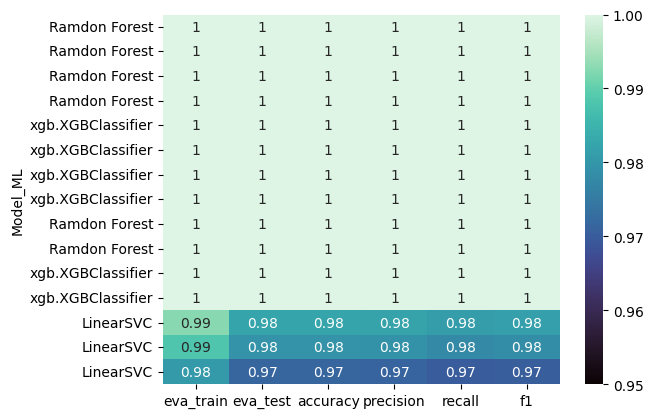

In [47]:
df=df_best_modelos
df = df.drop(columns=['method_outlier',"correl","method_scaled"])
df = df.set_index('Model_ML')

sns.heatmap(df, cmap='mako',vmin=0.95,annot=True)

<Axes: ylabel='Model_ML'>

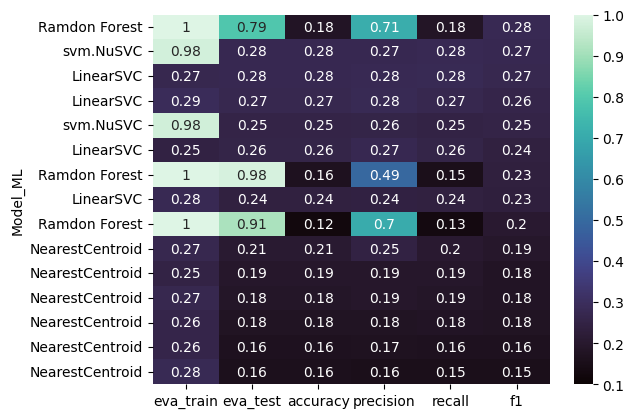

In [48]:
df_worse_modelos=df_modelos_resumen.sort_values(by='f1', ascending=False).tail(15).reset_index(drop=True)
df=df_worse_modelos
df = df.drop(columns=['method_outlier',"correl","method_scaled"])
df = df.set_index('Model_ML')

sns.heatmap(df, cmap='mako',vmin=0.1,annot=True)

<Axes: ylabel='Model_ML'>

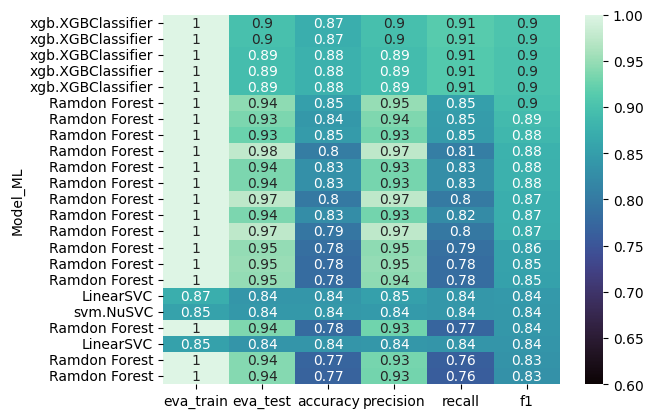

In [49]:
prop_base=0.4
delta=0.1
cot_inf,cot_sup=int(len(df_modelos_resumen) * prop_base),int(len(df_modelos_resumen) * (prop_base+delta))

df_middle_modelos=df_modelos_resumen.sort_values(by='f1', ascending=False).iloc[cot_inf:cot_sup,:].reset_index(drop=True)
df=df_middle_modelos
df = df.drop(columns=['method_outlier',"correl","method_scaled"])
df = df.set_index('Model_ML')

sns.heatmap(df, cmap='mako',vmin=0.6,annot=True)
#df_worse_modelos

# Análisis de resultados:

<span style="color:blue">Contexto:  </span>  
Como se menciono al inicio este proyecto sólo busca mostrar las herramientas que se tiene para tratar los datos y modelos de ML, por lo tanto, las condiciones asociadas no fueron verificadas. Por ejemplo, si queremos usar z-score para eliminar los puntos outliers, entonces debemos verificar que los datos tengan distribución normal. La distribución normal de los datos se puede verificar utilizando una gráfica Q-Q, un test de hipotesis como el test de Shapiro.

<span style="color:blue">Sección outliers:</span>    
- En la sección de outliers vimos que la visualización de los boxplot es mucho mejor cuando utilizamos el paramétro "hue=range_price", esto se puede ver con un ejemplo, si una fila representativa de range_price="muy bajo" y la cantidad de bateria, entonces la cantidad de bateria deberia ser un outlier para los datos de tipo range_price="alto".

<span style="color:blue">Sección Correlation Matrix:</span>      
- En la sección Correlation Matrix vimos que sólo once columnas estaban correlacionadas con la columna de la variable dependiente, "range_prices".
- Al eliminar las columnas no correlacionadas con la variable dependiente, "range_prices" notamos gran mejoría en los resultados de los modelos de clasificación. Es decir, los modelos de clasificación mejoraron sus resultados en general y se hicieron más rápidos de ejecutar. A parte de este punto, se reduce considerablemente el tiempo de entrenamiento.

<span style="color:blue">Sección de Resultados:  </span>
- En esta sección se pueden ver los resultados de todos los modelos. En esta sección, se tomo como instrumento de medida para ver el rendimiento del modelo a la medida "f1", pues esta ofrece un balance de medida entre los falsos positivos y falsos negativos. De aquí podemos determinar el rendimiento del modelo depende método de escalado (si es diferenciado o no) y el modelo de machine learning, en donde los modelos de random forest y XGBClassifier tuvieron mejores resultados.






